<a href="https://colab.research.google.com/github/yogaliu-ds/kaggle_House-Prices/blob/main/(0.14)%20pca_XGboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import modules and data

In [308]:
# Connect to the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [309]:
import pandas as pd
import numpy as np

# PCA
from sklearn.decomposition import PCA

# Train_test_split
from sklearn.model_selection import train_test_split

# Transformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Model
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import NuSVR, SVR
import xgboost as xgb

# pipeline
from sklearn.pipeline import make_pipeline

# Loss Measure
from sklearn.metrics import mean_squared_log_error

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Data
train = pd.read_csv('/content/drive/MyDrive/Kaggle/House Prices/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Kaggle/House Prices/test.csv')


In [310]:
# Oh, God, there are so many features
print(train.columns)
print(train.shape)
print(train.info())

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

# 2. Getting to know your data

In [50]:
plt.style.use('seaborn')

In [51]:
# SalePrice 
k = train.SalePrice.describe()
print(k)

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [29]:
# Find missing value
se = train.isna().sum()
se = se[se!=0]
print(se.sort_values(ascending=False))

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


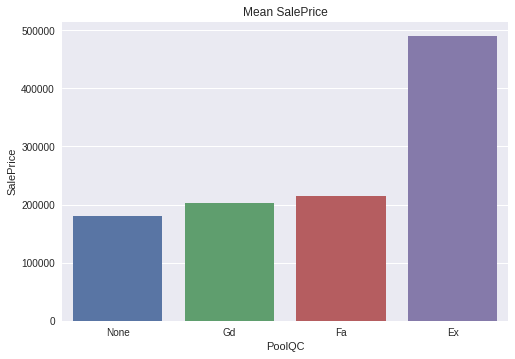

In [30]:
# Check features with many missing value
# PoolQC : PoolQC doesn't have many value, but I assume that it's a strong indicator when it has value 'Ex'.
k=train
k.PoolQC = k.PoolQC.fillna('None')
k = k.groupby('PoolQC')['SalePrice'].mean().sort_values()
sns.barplot(x=k.index, y=k)
plt.title('Mean SalePrice')
plt.show()

54
MiscFeature
False    182046.410384
True     151623.944444
Name: SalePrice, dtype: float64


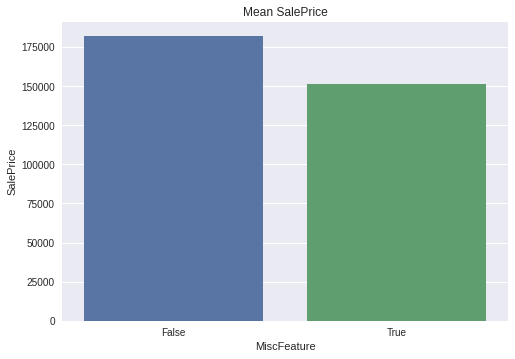

In [31]:
# MiscFeature : Looks like other feature isn't adorable in general
k= train
k.MiscFeature = (k.MiscFeature.isna() ==False)
print(k.MiscFeature.sum())
k = k.groupby('MiscFeature')['SalePrice'].mean()
k = k.replace({True:'True', False:'False'})
print(k)
sns.barplot(x=k.index, y=k)
plt.title('Mean SalePrice')
plt.show()

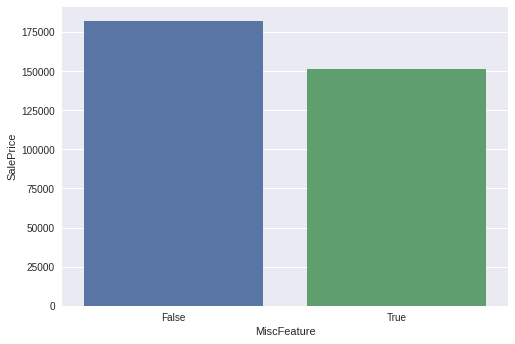

In [32]:
# Let's see in different categorizing. It's more clear.
k = train
k.MiscFeature = k.MiscFeature.fillna('None')
k = k.groupby('MiscFeature')['SalePrice'].mean().sort_values()
sns.barplot(x=k.index, y=k)

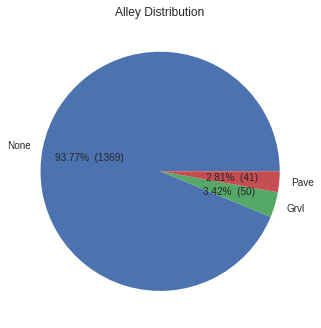

In [33]:
# Alley
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

k=train
k.Alley = k.Alley.fillna('None')
k = k.Alley.value_counts()
plt.pie(x=k, labels=k.index, autopct=make_autopct(k))
plt.title('Alley Distribution')
plt.show()

Alley
None    183452.131483
Pave    168000.585366
Grvl    122219.080000
Name: SalePrice, dtype: float64


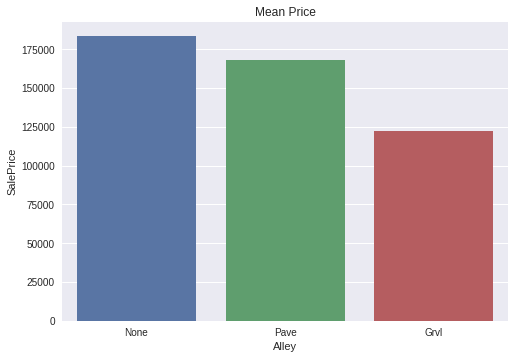

In [34]:
# Alley 
k = train
k = k.groupby('Alley')['SalePrice'].mean().sort_values(ascending =False)
print(k)
sns.barplot(x=k.index, y=k)
plt.title('Mean Price')
plt.show()

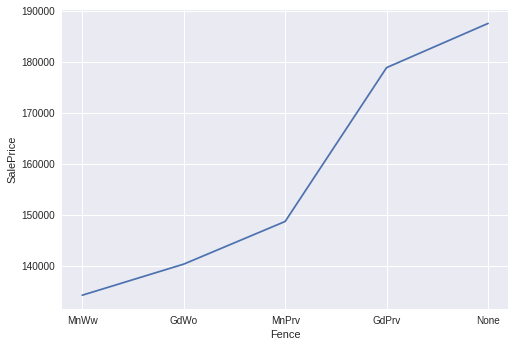

In [35]:
# Fence : See the order, It's interesting.
k = train
k.Fence = k.Fence.fillna('None')
k = k.groupby('Fence')['SalePrice'].mean().sort_values()
sns.lineplot(x=k.index, y=k)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


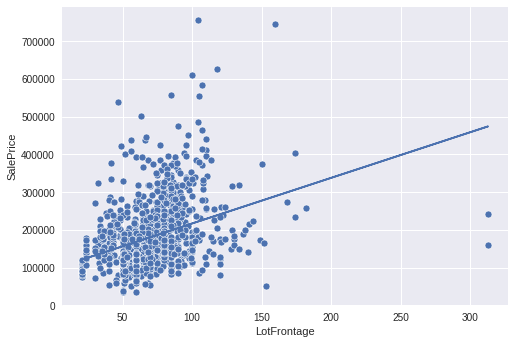

In [36]:
# LotFrontage
k = train[['LotFrontage', 'SalePrice']]
k.dropna(inplace=True)
k.isna().sum()

# scatterplot with regression line
x = k.LotFrontage
y = k.SalePrice

sns.scatterplot(x=x, y=y)
m, b = np.polyfit(x, y, 1)

plt.plot(x, m*x+b)
plt.show()

In [37]:
# Month and Year


# 3. Data preprocessing

In [311]:
# Drop the feaures with too many missing value
print(train.shape)
train = train.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage'], 1)

print(train.shape)

(1460, 81)
(1460, 74)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [312]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 74 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotArea        1460 non-null   int64  
 3   Street         1460 non-null   object 
 4   LotShape       1460 non-null   object 
 5   LandContour    1460 non-null   object 
 6   Utilities      1460 non-null   object 
 7   LotConfig      1460 non-null   object 
 8   LandSlope      1460 non-null   object 
 9   Neighborhood   1460 non-null   object 
 10  Condition1     1460 non-null   object 
 11  Condition2     1460 non-null   object 
 12  BldgType       1460 non-null   object 
 13  HouseStyle     1460 non-null   object 
 14  OverallQual    1460 non-null   int64  
 15  OverallCond    1460 non-null   int64  
 16  YearBuilt      1460 non-null   int64  
 17  YearRemodAdd   1460 non-null   int64  
 18  RoofStyl

In [313]:
# Those featrues with NaN meaning None
na_list = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageYrBlt']
for col in na_list:
  train[col] = train[col].fillna('NA')

# Setting 'NA' is just for convenience. If we want to be more accurate, we should use other statistics.

In [314]:
# Electrical, MasVnrArea, MasVnrType : Few missing value, so we just drop that row
train.dropna(subset=['Electrical', 'MasVnrType', 'MasVnrArea'], inplace=True)


In [315]:
# Done with missing value, Double Check
print(train.isna().sum()[train.isna().sum()!=0])
print(train.shape)

Series([], dtype: int64)
(1451, 74)


In [316]:
# Dealing with dtype
# MSSubClass : should be category
train.MSSubClass = train.MSSubClass.astype('category')
print(train.MSSubClass.dtype)

category


In [317]:
# YrSold, MoSold
for col in ['YrSold', 'MoSold']:
  train[col] = train[col].astype(str)

In [318]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1451 entries, 0 to 1459
Data columns (total 74 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   MSSubClass     1451 non-null   category
 1   MSZoning       1451 non-null   object  
 2   LotArea        1451 non-null   int64   
 3   Street         1451 non-null   object  
 4   LotShape       1451 non-null   object  
 5   LandContour    1451 non-null   object  
 6   Utilities      1451 non-null   object  
 7   LotConfig      1451 non-null   object  
 8   LandSlope      1451 non-null   object  
 9   Neighborhood   1451 non-null   object  
 10  Condition1     1451 non-null   object  
 11  Condition2     1451 non-null   object  
 12  BldgType       1451 non-null   object  
 13  HouseStyle     1451 non-null   object  
 14  OverallQual    1451 non-null   int64   
 15  OverallCond    1451 non-null   int64   
 16  YearBuilt      1451 non-null   int64   
 17  YearRemodAdd   1451 non-null   in

# 4. Modeling

In [319]:
train_temp = train

# Not sure about if we should use get_dummies
train_temp = pd.get_dummies(train_temp, drop_first=False)
print(train_temp.shape)
# Set X, y 
X = train_temp.drop(columns=['SalePrice'], axis=1)
y = train_temp.SalePrice.values 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

# Pipeline
scaler = StandardScaler()
# normalizer = MinMaxScaler()
pca = PCA(n_components = 'mle')
rf =RandomForestRegressor()
xgb = xgb.XGBRegressor()

# svr = NuSVR()
# svr = SVR()

pipe = make_pipeline(scaler, pca, xgb)

# Fit and predict
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

loss = np.sqrt(mean_squared_log_error(y_pred, y_test))
print(loss)



(1451, 405)
[09:28:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.17540812540257497


In [45]:
print(train_temp.columns)

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=425)


# 5. Submission

In [46]:
z = test.isna().sum()
print(z[z != 0])

MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
GarageArea         1
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64
